Libraries

In [1]:
import tensorflow as tf
import numpy as np
import keras_cv
import matplotlib.pyplot as plt
import cv2 as cv
import scipy
from scipy.optimize import curve_fit
import sklearn
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import io
import os
import os.path
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import backend as K
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Add, GlobalAveragePooling2D, Conv2D, MaxPool2D, MaxPooling2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling, RandomContrast, Input, Lambda, Activation
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import  BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from tensorboard.plugins.hparams import api as hp

Using TensorFlow backend


c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_directory = r'C:\Users\Admin\Documents\GitHub\Face-Recognition-LenetModel\faces\Train'
val_directory = r'C:\Users\Admin\Documents\GitHub\Face-Recognition-LenetModel\faces\Test'
CLASS_NAME = ['Alizar Waqar', 'Gulfam Asghar', 'Muhammad Arslan', 'Muhammad Shabbir', 'Muhammad Yaseen', 
            'Sufyan Ashraf','Talal Ahmad','Usman Ali']
CONFIGURATION = {
    'BATCH_SIZE':32,
    'IM_SIZE': 64,
    'LEARNING_RATE': 0.001,
    'N_EPOCHS': 20,
    'DROPOUT_RATE': 0.0,
    'REGULARIZATION_RATE':0.0,
    'N_FILTERS': 6,
    'KERNEL_SIZE':3,
    'N_STRIDES': 1,
    'POOL_SIZE':2,
    'N_DENSE_1':100,
    'N_DENSE_2':10,
    'NUM_CLASSES':8
}


In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 1721 files belonging to 8 classes.


In [4]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CLASS_NAME,
    color_mode='rgb',
    batch_size=CONFIGURATION['BATCH_SIZE'],
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    shuffle=True,
    seed=99,
)

Found 308 files belonging to 8 classes.


In [5]:
augment_layers = tf.keras.Sequential([
    RandomRotation(factor= (-0.025,0.025)),
    RandomFlip(mode='horizontal'),
    RandomContrast(factor=0.1)
])

In [6]:
def augment_layer(image, label):
    return augment_layers(image, training = True), label

In [289]:
# def box(lamda):
  
#   r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
#   r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

#   r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
#   r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

#   r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
#   r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

#   x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
#   y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

#   r_w = x_b_r - r_x
#   if(r_w == 0):
#     r_w  = 1

#   r_h = y_b_r - r_y
#   if(r_h == 0):
#     r_h = 1

#   return r_y, r_x, r_h, r_w

In [290]:
# def cutmix(train_dataset_1, train_dataset_2):
#   (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

#   lamda = tfp.distributions.Beta(2,2)
#   lamda = lamda.sample(1)[0]
  
#   r_y, r_x, r_h, r_w = box(lamda)
#   crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
#   pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

#   crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
#   pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

#   image = image_1 - pad_1 + pad_2

#   lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
#   label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

#   return image, label

In [291]:
# train_dataset_1 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
# train_dataset_2 = train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)

# mixed_dataset = tf.data.Dataset.zip((train_dataset_1, train_dataset_2))

In [8]:
training_dataset = (
    train_dataset.map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# training_dataset = (
#     train_dataset.prefetch(tf.data.AUTOTUNE)
# )

In [9]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [10]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255),
])

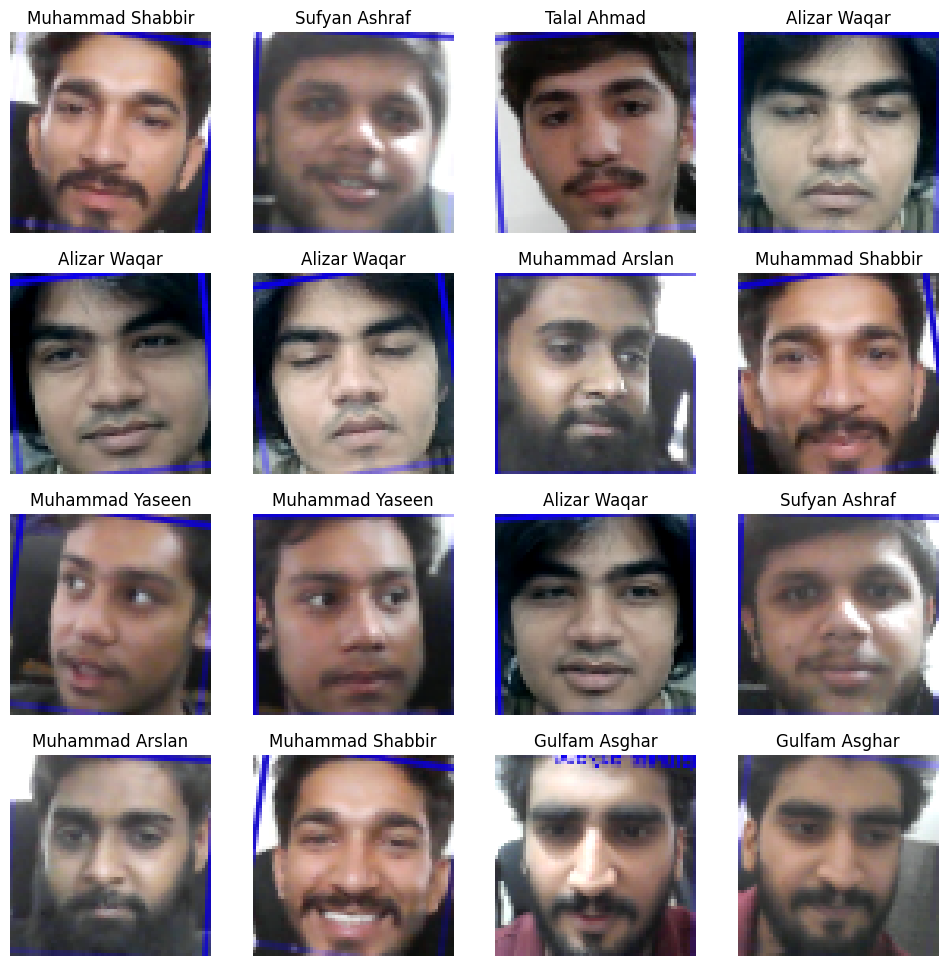

In [11]:
plt.figure(figsize = (12,12))
for images, labels in training_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CLASS_NAME[tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis('off')

In [ ]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),
    
    resize_rescale_layers,
    
    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),
    
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),
    
    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])
lenet_model.summary()


In [ ]:
loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name = "accuracy")
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss= loss_function, metrics = metrics)

In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose= 1)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['training_loss','val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['training_accuracy','val_accuracy'])
plt.show()

In [ ]:
test_loss, test_accuracy = lenet_model.evaluate(validation_dataset)
print("Test accuracy:", test_accuracy)

In [ ]:
plt.figure(figsize = (15,15))
for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title('True Label: ' + CLASS_NAME[tf.argmax(labels[i], axis = 0).numpy()] + '\n' + 'Predicted Label: ' + 
              CLASS_NAME[tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)),axis = -1).numpy()[0]])
    plt.axis('off')

In [ ]:
predicted = []
labels = []
for im, label, in validation_dataset:
    predicted.append(lenet_model(im))
    labels.append(label.numpy())

In [ ]:
print(np.argmax(labels[:-1], axis= -1).flatten())
print(np.argmax(predicted[:-1], axis= -1).flatten())

In [ ]:
pred = np.argmax(predicted[:-1], axis= -1).flatten()
lab = np.argmax(labels[:-1], axis= -1).flatten()

cm = confusion_matrix(lab, pred)
print(cm)

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True,)
plt.title("HeatMap")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
#lenet_model.save('Face Detection.h5')

In [296]:
class CustomConv2D(Layer):
  def __init__(self, n_filters, kernel_size, n_strides, padding = 'valid'):
    super(CustomConv2D, self).__init__(name = 'custom_conv2d')

    self.conv = Conv2D(
        filters = n_filters,
        kernel_size = kernel_size,
        activation = 'relu',
        strides = n_strides,
        padding = padding)
    
    self.batch_norm = BatchNormalization()

  def call(self, x, training = True):

    x = self.conv(x)
    x = self.batch_norm(x, training)

    return x

In [297]:
class ResidualBlock(Layer):
  def __init__(self, n_channels, n_strides = 1):
    super(ResidualBlock, self).__init__(name = 'res_block')

    self.dotted = (n_strides != 1)

    self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding = "same")
    self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding = "same")

    self.activation = Activation('relu')

    if self.dotted:
      self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides)
    
  def call(self, input, training):

    x = self.custom_conv_1(input, training)
    x = self.custom_conv_2(x, training)

    if self.dotted:
      x_add = self.custom_conv_3(input, training)
      x_add = Add()([x, x_add])
    else:
      x_add = Add()([x, input])

    return self.activation(x_add)

     

In [298]:
class ResNet34(Model):
  def __init__(self,):
    super(ResNet34, self).__init__(name = 'resnet_34')
    
    self.conv_1 = CustomConv2D(64, 7, 2, padding = 'same')
    self.max_pool = MaxPooling2D(3,2)
    
    self.conv_2_1 = ResidualBlock(64)
    self.conv_2_2 = ResidualBlock(64)
    self.conv_2_3 = ResidualBlock(64)
    
    self.conv_3_1 = ResidualBlock(128, 2)
    self.conv_3_2 = ResidualBlock(128)
    self.conv_3_3 = ResidualBlock(128)
    self.conv_3_4 = ResidualBlock(128)

    self.conv_4_1 = ResidualBlock(256, 2)
    self.conv_4_2 = ResidualBlock(256)
    self.conv_4_3 = ResidualBlock(256)
    self.conv_4_4 = ResidualBlock(256)
    self.conv_4_5 = ResidualBlock(256)
    self.conv_4_6 = ResidualBlock(256)
    
    self.conv_5_1 = ResidualBlock(512, 2)
    self.conv_5_2 = ResidualBlock(512)
    self.conv_5_3 = ResidualBlock(512)

    self.global_pool = GlobalAveragePooling2D()

    self.fc_3 = Dense(CONFIGURATION["NUM_CLASSES"], activation = 'softmax')
    
  def call(self, x, training = True):
    x = self.conv_1(x)
    x = self.max_pool(x)

    x = self.conv_2_1(x, training)
    x = self.conv_2_2(x, training)
    x = self.conv_2_3(x, training)
    
    x = self.conv_3_1(x, training)
    x = self.conv_3_2(x, training)
    x = self.conv_3_3(x, training)
    x = self.conv_3_4(x, training)
    
    x = self.conv_4_1(x, training)
    x = self.conv_4_2(x, training)
    x = self.conv_4_3(x, training)
    x = self.conv_4_4(x, training)
    x = self.conv_4_5(x, training)
    x = self.conv_4_6(x, training)
    
    x = self.conv_5_1(x, training)
    x = self.conv_5_2(x, training)
    x = self.conv_5_3(x, training)

    x = self.global_pool(x)
    
    return self.fc_3(x)

In [299]:
resnet_34 = ResNet34()
resnet_34(tf.zeros([1,64,64,3]), training = False)
resnet_34.summary()


Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2  multiple                  9728      
 D)                                                              
                                                                 
 max_pooling2d_24 (MaxPooli  multiple                  0         
 ng2D)                                                           
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

In [300]:
loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name = "accuracy")
resnet_34.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss= loss_function, metrics = metrics)

In [ ]:
history = lenet_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = CONFIGURATION['N_EPOCHS'],
    verbose= 1)

In [12]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 [==============================] - 235s 3us/step


In [13]:
backbone.trainable = False

In [21]:
pretrained_model = tf.keras.Sequential([
    Input(shape = (None, None,3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),
    
    ])
pretrained_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 2, 2, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 100)               179300    
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 10)                1010      
                                                      

In [22]:
loss_function = CategoricalCrossentropy()
metrics = CategoricalAccuracy(name = "accuracy")
pretrained_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss= loss_function, metrics = metrics)

In [23]:
history = pretrained_model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = 10,
    verbose= 1)

Epoch 1/10
54/54 [==============================] - 35s 450ms/step - loss: 0.6830 - accuracy: 0.8588 - val_loss: 0.7401 - val_accuracy: 0.9318
Epoch 2/10
54/54 [==============================] - 23s 423ms/step - loss: 0.1542 - accuracy: 0.9878 - val_loss: 0.4000 - val_accuracy: 0.9545
Epoch 3/10
54/54 [==============================] - 25s 454ms/step - loss: 0.0689 - accuracy: 0.9959 - val_loss: 0.1792 - val_accuracy: 0.9805
Epoch 4/10
54/54 [==============================] - 25s 454ms/step - loss: 0.0399 - accuracy: 0.9983 - val_loss: 0.0921 - val_accuracy: 0.9838
Epoch 5/10
54/54 [==============================] - 24s 438ms/step - loss: 0.0348 - accuracy: 0.9913 - val_loss: 0.0545 - val_accuracy: 0.9903
Epoch 6/10
54/54 [==============================] - 24s 434ms/step - loss: 0.0263 - accuracy: 0.9971 - val_loss: 0.0589 - val_accuracy: 0.9935
Epoch 7/10
54/54 [==============================] - 23s 428ms/step - loss: 0.0202 - accuracy: 0.9977 - val_loss: 0.1376 - val_accuracy: 0.9481

In [24]:
test_loss, test_accuracy = pretrained_model.evaluate(validation_dataset)
print("Test accuracy:", test_accuracy)

10/10 [==============================] - 3s 328ms/step - loss: 0.0370 - accuracy: 0.9870
Test accuracy: 0.9870129823684692


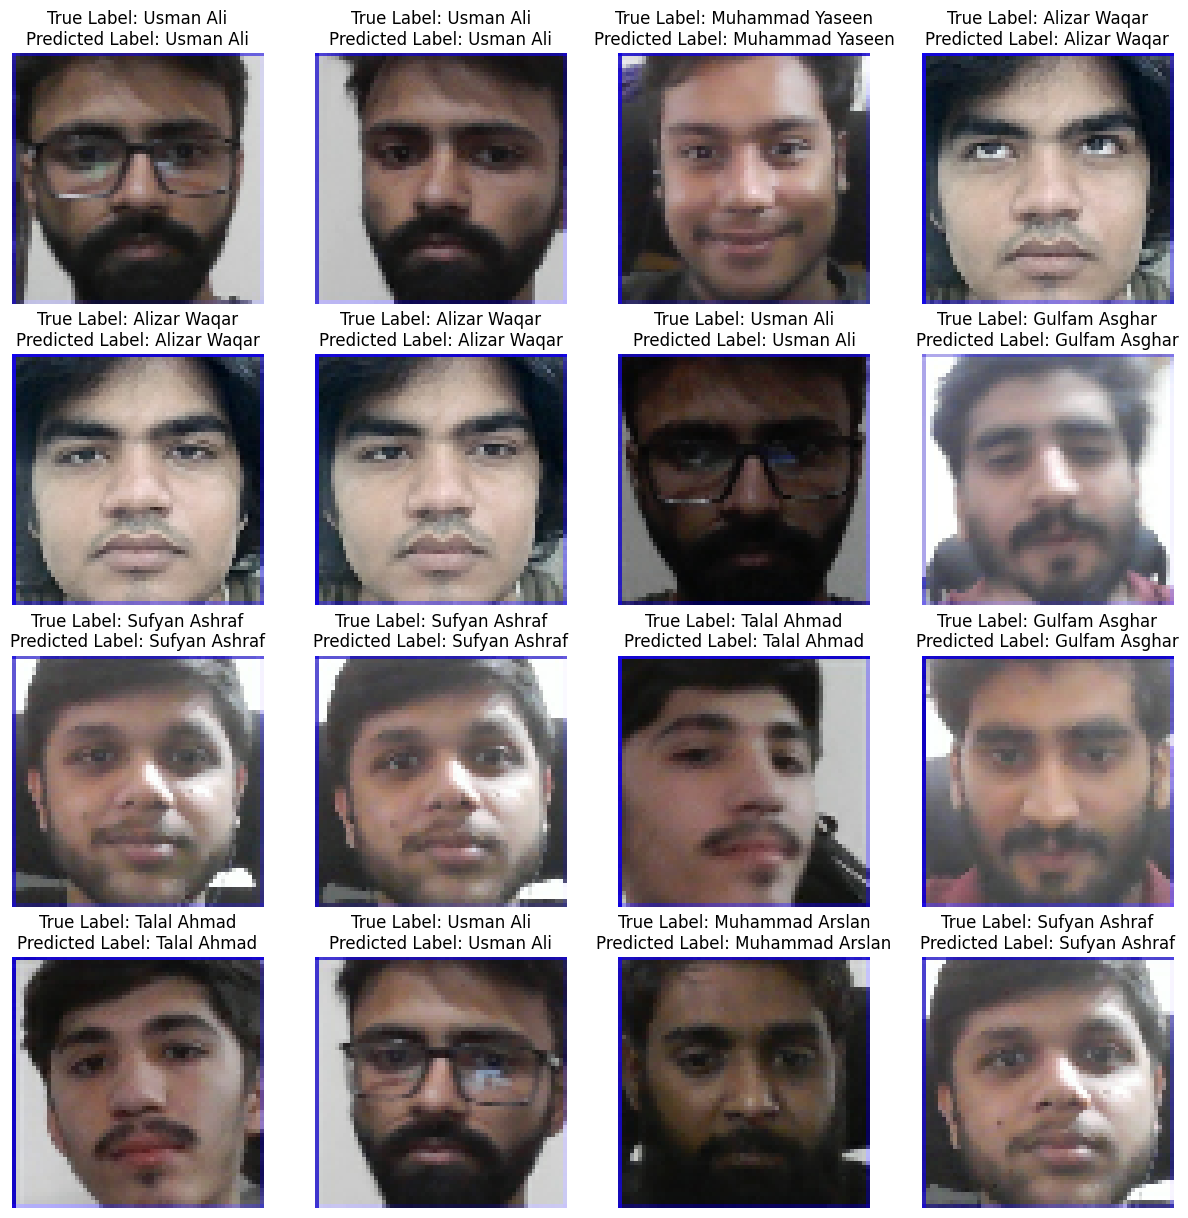

In [25]:
plt.figure(figsize = (15,15))
for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title('True Label: ' + CLASS_NAME[tf.argmax(labels[i], axis = 0).numpy()] + '\n' + 'Predicted Label: ' + 
              CLASS_NAME[tf.argmax(pretrained_model(tf.expand_dims(images[i], axis = 0)),axis = -1).numpy()[0]])
    plt.axis('off')

In [26]:
pretrained_model.save('pretrainedmodel.h5')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
